In [38]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import datetime
from sklearn.preprocessing import LabelEncoder

In [39]:
# Load data from csv file

users = pd.read_csv('user_info.csv')
products = pd.read_csv('product_info.csv')
interactions = pd.read_csv('interaction_data.csv')

In [59]:
#Transform Expiration Date to datetime format
products['Expiration Date'] = pd.to_datetime(products['Expiration Date'])

#creates label for each of the Interaction Type values
le = LabelEncoder()
interactions['Interaction Type'] = le.fit_transform(interactions['Interaction Type'])

#Merge interactions and products
df = pd.merge(interactions, products, on='Product ID', how='inner')

# Define the date threshold as 60 days from the current date
cutoff_date = pd.Timestamp.now() + pd.Timedelta(days=60)

# Filter out the rows that have "Expiration Date" higher than the threshold
filtered_df = df[ pd.to_datetime(df["Expiration Date"]).dt.date <= cutoff_date.date() ]
# Aggregate by product
agg_interactions = filtered_df.groupby('Product Name').agg(mean_interaction = ('Interaction Type', 'mean'),
                                                number_of_interactions = ('Interaction Type', 'count')).reset_index()

# Keep the products with more tha 50 interactions
agg_interactions_super100 = agg_interactions[agg_interactions['number_of_interactions']>50]
agg_interactions_super100.info()    

# Check the moust interact products
agg_interactions_super100.sort_values(by='number_of_interactions', ascending=False).head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Product Name            75 non-null     object 
 1   mean_interaction        75 non-null     float64
 2   number_of_interactions  75 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.3+ KB


,Product Name,mean_interaction,number_of_interactions
43,Logitech ClearChat Comfort/USB Headset H390,1.519380,129
23,DIXON Oriole Pencils,1.396694,121
57,Sauder Cornerstone Collection Library,1.420168,119
34,GuestStacker Chair with Chrome Finish Legs,1.521008,119
14,"Bevis Oval Conference Table, Walnut",1.401709,117


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7534 entries, 0 to 7533
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   User ID                7534 non-null   int64         
 1   Product ID             7534 non-null   int64         
 2   Interaction Type       7534 non-null   int64         
 3   Interaction Timestamp  7534 non-null   object        
 4   Product Name           7534 non-null   object        
 5   Category               7534 non-null   object        
 6   Expiration Date        7534 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 470.9+ KB


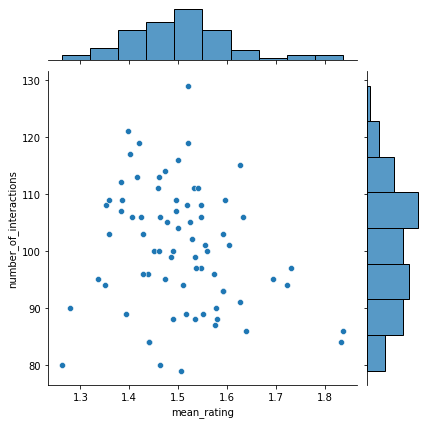

In [55]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_interactions', data=agg_interactions_super100)

df_S10 = pd.merge(filtered_df, agg_interactions_super100[['Product Name']], on='Product Name', how='inner')
df_S10.info()


In [56]:
# Create user-item matrix
matrix = df_S10.pivot_table(index='Product Name', columns='User ID', values='Interaction Type')
matrix.head()


User ID,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Product Name,,,,,,,,,,,,,,,,,,,,,
Acme Box Cutter Scissors,0.0,NaN,NaN,2.0,0.0,3.0,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.0,3.00,NaN,NaN,3.0,NaN,1.0
Advantus Rolling Storage Box,NaN,0.000000,0.000000,0.0,2.0,3.0,NaN,2.0,3.0,0.0,...,0.000000,NaN,NaN,NaN,3.00,1.0,2.666667,NaN,2.5,NaN
Advantus T-Pin Paper Clips,3.0,0.000000,2.000000,NaN,NaN,1.0,NaN,NaN,3.0,0.0,...,1.666667,NaN,1.0,NaN,1.25,NaN,NaN,0.0,2.0,NaN
Ames Color-File Green Diamond Border X-ray Mailers,0.0,NaN,NaN,NaN,2.0,NaN,NaN,3.0,1.5,NaN,...,NaN,2.0,NaN,2.0,2.00,2.0,1.000000,1.0,NaN,NaN
"Ampad Poly Cover Wirebound Steno Book, 6"" x 9"" Assorted Colors, Gregg Ruled",3.0,2.333333,1.666667,0.0,NaN,1.0,NaN,1.0,NaN,NaN,...,1.000000,NaN,1.0,NaN,2.00,NaN,1.500000,NaN,NaN,2.0


In [57]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()
# Item similarity matrix using Pearson correlation
item_similarity = matrix_norm.T.corr()
item_similarity.head()


Product Name,Acme Box Cutter Scissors,Advantus Rolling Storage Box,Advantus T-Pin Paper Clips,Ames Color-File Green Diamond Border X-ray Mailers,"Ampad Poly Cover Wirebound Steno Book, 6"" x 9"" Assorted Colors, Gregg Ruled","Atlantic Metals Mobile 4-Shelf Bookcases, Custom Colors",Avery 473,Avery 480,Avery 488,Avery 508,...,"Vinyl Coated Wire Paper Clips in Organizer Box, 800/Box","Westinghouse Floor Lamp with Metal Mesh Shade, Black","White Dual Perf Computer Printout Paper, 2700 Sheets, 1 Part, Heavyweight, 20 lbs., 14 7/8 x 11",Wilson Jones Standard D-Ring Binders,Wilson Jones Turn Tabs Binder Tool for Ring Binders,Xerox 1883,Xerox 1887,Xerox 1908,Xerox 1946,Xerox 217
Product Name,,,,,,,,,,,,,,,,,,,,,
Acme Box Cutter Scissors,1.000000,0.190361,-0.017191,-0.110436,-0.149678,0.021432,-0.074664,-0.152454,0.163785,0.147892,...,0.275787,-0.070219,-0.248018,0.062690,0.119130,-0.314616,-0.048315,0.163848,0.202317,-0.180998
Advantus Rolling Storage Box,0.190361,1.000000,0.056914,-0.055459,0.203048,0.223559,-0.223605,-0.045740,-0.079689,-0.145005,...,-0.154874,0.035700,0.027636,-0.002834,0.260580,-0.166117,-0.109579,-0.000056,0.103115,-0.003135
Advantus T-Pin Paper Clips,-0.017191,0.056914,1.000000,-0.257886,0.016577,0.115621,-0.065151,-0.132929,0.106749,-0.195549,...,0.049605,-0.220078,0.210881,-0.160865,0.167272,-0.123521,0.176108,0.159891,-0.226386,0.309982
Ames Color-File Green Diamond Border X-ray Mailers,-0.110436,-0.055459,-0.257886,1.000000,-0.087863,0.089232,0.202420,0.111978,0.190789,-0.056921,...,0.129483,-0.039160,-0.110265,-0.049093,-0.024159,0.138543,-0.174566,-0.018526,0.247041,-0.087981
"Ampad Poly Cover Wirebound Steno Book, 6"" x 9"" Assorted Colors, Gregg Ruled",-0.149678,0.203048,0.016577,-0.087863,1.000000,0.270869,0.116397,0.119789,-0.099485,-0.313367,...,-0.072241,0.222592,0.269029,0.061455,-0.128172,-0.259116,0.217872,0.286712,0.258658,0.005255


In [54]:
# Item-based recommendation function
def item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3):
  import operator
  # Products that the target user has not interact with
  picked_userid_unsee = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unsee = picked_userid_unsee[picked_userid_unsee[picked_userid]==True]['Product Name'].values.tolist()

  # Products that the target user has interact
  picked_userid_see = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={picked_userid:'Interaction Type'})
  
  # Dictionary to save the unsee product and predicted a interaction
  interaction_prediction ={}  

  # Loop through unsee products          
  for picked_item in picked_userid_unsee: 
    # Calculate the similarity score of the picked products with other products
    picked_product_similarity_score = item_similarity[[picked_item]].reset_index().rename(columns={picked_item:'similarity_score'})
    # Rank the similarities between the picked user see products and the unsee products.
    picked_userid_see_similarity = pd.merge(left=picked_userid_see, 
                                                right=picked_product_similarity_score, 
                                                on='Product Name', 
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted interaction using weighted average of similarity scores and the interactions from user
    predicted_interaction = round(np.average(picked_userid_see_similarity["Interaction Type"], 
                                        weights=picked_userid_see_similarity['similarity_score']), 6)
    # Save the predicted interaction in the dictionary
    interaction_prediction[picked_item] = predicted_interaction
    # Return the top recommended products
  return sorted(interaction_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

# Get recommendations
recommended_product = item_based_rec(picked_userid=97, number_of_similar_items=50, number_of_recommendations =3)
print(recommended_product)

[('Coloredge Poster Frame', 2.771966), ('Avery Durable Slant Ring Binders, No Labels', 0.651582), ('Iris Project Case', 0.609068)]
